### To run the code, you should have the dataset in the same folder:
```bash
Sentiment Analysis
├── Turkish-Movie Dataset
│   ├── movie_outerN.txt
│   ├── movie_outerP.txt
│   ├── movie_testN.txt
|   └─────────────────
├── Turkish-Movie Sentiment Analysis.ipynb
├── dataset.py
├── turkish-movie-converter.py
├── results.txt
└── README.md
```

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import tensorflow as tf  # pytorch for the model, tensorflow for tokenizer
import gensim
from dataset import Dataset

c:\Users\karab\Desktop\turkish-word-embeddings\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)
torch.cuda.get_device_name(0)

1.13.1+cu117


'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# read train and test csv
traindf = pd.read_csv("data2/train.csv")
testdf = pd.read_csv("data2/test.csv")

# get label
trainy = traindf['sentiment'].values
testy = testdf['sentiment'].values

In [7]:
len(traindf), len(testdf)

(286854, 31873)

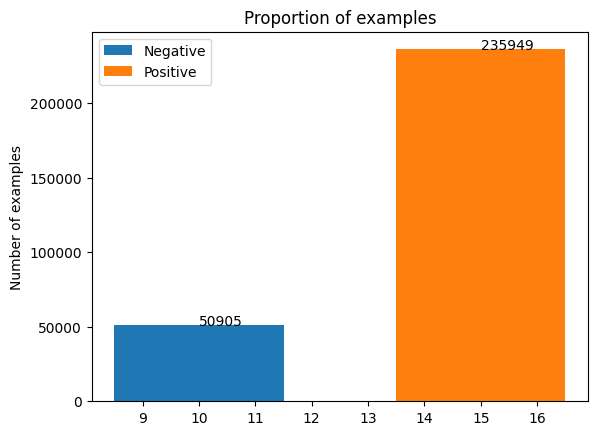

In [8]:
# visualize number of negatives and positive reviews
import matplotlib.pyplot as plt

negatives = traindf[traindf['sentiment'] == 0].shape[0]
positives = traindf[traindf['sentiment'] == 1].shape[0]

plt.bar(10, negatives, 3, label = 'Negative')
plt.bar(15, positives, 3, label = 'Positive')
# add numbers to the side of the bar
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.text(10, negatives, str(negatives))
plt.text(15, positives, str(positives))
plt.show()

In [7]:
# K-FOLD CROSS VALIDATION SETUP
kf = model_selection.StratifiedKFold(n_splits=5)

# assign folds to [0, 1, 2, 3, 4]
for fold, (train_, valid_) in enumerate(kf.split(X=traindf, y=trainy)):
    traindf.loc[valid_, 'kfold'] = fold

print("Total number of rows: ", traindf.shape[0])
print("Number of rows with kfold = 0", traindf[traindf.kfold==0].shape[0])
print("Number of rows with kfold = 1", traindf[traindf.kfold==1].shape[0])
print("Number of rows with kfold = 2", traindf[traindf.kfold==2].shape[0])
print("Number of rows with kfold = 3", traindf[traindf.kfold==3].shape[0])
print("Number of rows with kfold = 4", traindf[traindf.kfold==4].shape[0])

Total number of rows:  16100
Number of rows with kfold = 0 3220
Number of rows with kfold = 1 3220
Number of rows with kfold = 2 3220
Number of rows with kfold = 3 3220
Number of rows with kfold = 4 3220


In [27]:
MODEL = "C:/Users/karab/Desktop/Models/bert-decontextualized-static.wv"
MAX_LEN = 128 # maximum length for a sentence
DIM = 768
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 5

In [30]:
#load fasttext embeddings
print('loading word embeddings...')
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(
            MODEL,
            binary=False,
            no_header=False
        )

loading word embeddings...


In [11]:
print(len(word_vectors))
word_vectors["bilgisayar"].shape  # 300 dimensions

1573013


(300,)

In [19]:
class LSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(LSTM, self).__init__()
        # Number of words = number of rows in embedding matrix
        num_words = embedding_matrix.shape[0]
        # Dimension of embedding is num of columns in the matrix
        embedding_dim = embedding_matrix.shape[1]
        # Define an input embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_words,
                                      embedding_dim=embedding_dim)
        # Embedding matrix actually is collection of parameter
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
        # Because we use pretrained embedding (GLove, Fastext,etc) so we turn off requires_grad-meaning we do not train gradient on embedding weight
        self.embedding.weight.requires_grad = False
        # LSTM with hidden_size = 16
        self.lstm = nn.LSTM(
                            embedding_dim, 
                            16,
                            bidirectional=False,
                            batch_first=True,
                             )
        self.out = nn.Linear(32, 1)
    def forward(self, x):
        # pass input (tokens) through embedding layer
        x = self.embedding(x)
        # fit embedding to LSTM
        hidden, _ = self.lstm(x)
        # apply mean and max pooling on lstm output
        avg_pool= torch.mean(hidden, 1)
        max_pool, index_max_pool = torch.max(hidden, 1)
        # concat avg_pool and max_pool (so we have 256 size, also because this is bidirectional ==> 256*2 = 512)
        out = torch.cat((avg_pool, max_pool), 1)
        # fit out to self.out to conduct dimensionality reduction from 512 to 1
        out = self.out(out)
        # return output
        return out

In [20]:
def train(data_loader, model, optimizer, device):
    """
    this is model training for one epoch
    data_loader:  this is torch dataloader, just like dataset but in torch and devide into batches
    model : lstm
    optimizer : torch optimizer : adam
    device:  cuda or cpu
    """
    # set model to training mode
    model.train()
    # go through batches of data in data loader
    for data in data_loader:
        reviews = data['review']
        targets = data['target']
        # move the data to device that we want to use
        reviews = reviews.to(device, dtype = torch.long)
        targets = targets.to(device, dtype = torch.float)
        # clear the gradient
        optimizer.zero_grad()
        # make prediction from model
        predictions = model(reviews)
        # caculate the losses
        loss = nn.BCEWithLogitsLoss()(predictions, targets.view(-1,1))
        # backprob
        loss.backward()
        #single optimization step
        optimizer.step()

In [21]:
def evaluate(data_loader, model, device):
    final_predictions = []
    final_targets = []
    model.eval()
    # turn off gradient calculation
    with torch.no_grad():
        for data in data_loader:
            reviews = data['review']
            targets = data['target']
            reviews = reviews.to(device, dtype = torch.long)
            targets = targets.to(device, dtype=torch.float)
            # make prediction
            predictions = model(reviews)
            # move prediction and target to cpu
            predictions = predictions.cpu().numpy().tolist()
            targets = targets.cpu().numpy().tolist()
            # add predictions to final_prediction
            final_predictions.extend(predictions)
            final_targets.extend(targets)
    return final_predictions, final_targets

In [22]:
def create_embedding_matrix(word_index, embedding_dict=None, dim=300):
    """
     this function create the embedding matrix save in numpy array
    :param word_index: a dictionary with word: index_value
    :param embedding_dict: a dict with word embedding
    :d_model: the dimension of word pretrained embedding
    :return a numpy array with embedding vectors for all known words
    """
    embedding_matrix = np.zeros((len(word_index) + 1, dim))
    ## loop over all the words
    for word, index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index] = embedding_dict[word]
    return embedding_matrix

# embedding_dict['word'] = vector
# word_index['word'] = index
# embedding_matrix[index] = vector

In [23]:
traindf['review'].values.tolist()[:5] # list of sentences

['Bu yorumu üçüncü defadır yazıyorum inatla ve beyazperde de her nedense aynı inatla yayına almadı bir türlü yazımı :(((Filmi izledikten sonra beyazperde.com’daki künyesinde türünün eksik yazıldığını farkettim. Korku ve bilimkurgunun yanı sıra bir komedi filmi de Undead...Korku, bilimkurgu ve komedi unsurlarının harmanlanması sıradışı bir fikir aslında. Ancak ne var ki, filmdeki oyunculuk performansları yerlerde sürünüyor ve filmin kalitesine ciddi darbe vurmakta bu husus. Onun dışında, diyaloglarının da zayıf kaldığı başka bir gerçek filmle ilgili...Filmin olumsuz yanlarının yanında olumlu yanları da var şüphesiz. Undead’de en çok beğendiğim şey özel efektler oldu. Özel efekt delisi değilim esasen ancak, bilimkurgu unsurlarının inandırıcılığı açısından önemli olan özel efekt konusu Undead’de başarılı bana göre. Ancak özel efektlerinin ve konusunun dışında filmde kayda değer başka birşey gördüm desem yalan olur...İzlemezseniz pek pişman olmazsınız bana göre. Yine de karar sizin :)))\n'

In [24]:
# STEP 1: Tokenization
# use tf.keras for tokenization,  
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(traindf['review'].values.tolist())

In [25]:
print('Load embeddings')
embedding_matrix = create_embedding_matrix(tokenizer.word_index, embedding_dict=word_vectors, dim=DIM)


for fold in range(5):
    # STEP 2: cross validation
    train_df = traindf[traindf.kfold != fold].reset_index(drop=True)
    valid_df = traindf[traindf.kfold == fold].reset_index(drop=True)
    
    # STEP 3: pad sequence
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    
    # zero padding
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain, maxlen=MAX_LEN)
    xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
    
    # STEP 4: initialize dataset class for training
    train_dataset = Dataset(reviews=xtrain, targets=train_df['sentiment'].values)
    
    # STEP 5: Load dataset to Pytorch DataLoader
    # after we have train_dataset, we create a torch dataloader to load train_dataset class based on specified batch_size
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = TRAIN_BATCH_SIZE, num_workers=2)
    # initialize dataset class for validation
    valid_dataset = Dataset(reviews=xtest, targets=valid_df['sentiment'].values)
    valid_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
    
    # STEP 6: Running 
    device = torch.device('cuda')
    # feed embedding matrix to lstm
    model_fasttext = LSTM(embedding_matrix)
    # set model to cuda device
    model_fasttext.to(device)
    # initialize Adam optimizer
    optimizer = torch.optim.Adam(model_fasttext.parameters(), lr=1e-3)
    
    print('training model')

    for epoch in tqdm(range(EPOCHS)):
        # train one epoch
        train(train_data_loader, model_fasttext, optimizer, device)
        # validate
        outputs, targets = evaluate(valid_data_loader, model_fasttext, device)
        # threshold
        outputs = np.array(outputs) >= 0.5
        # calculate accuracy
        accuracy = metrics.accuracy_score(targets, outputs)
        print(f'FOLD:{fold}, epoch: {epoch}, accuracy_score: {accuracy}')

Load embeddings
training model


 20%|██        | 1/5 [00:06<00:25,  6.31s/it]

FOLD:0, epoch: 0, accuracy_score: 0.7913043478260869


 40%|████      | 2/5 [00:12<00:18,  6.24s/it]

FOLD:0, epoch: 1, accuracy_score: 0.8211180124223603


 60%|██████    | 3/5 [00:18<00:12,  6.14s/it]

FOLD:0, epoch: 2, accuracy_score: 0.8291925465838509


 80%|████████  | 4/5 [00:25<00:06,  6.37s/it]

FOLD:0, epoch: 3, accuracy_score: 0.8391304347826087


100%|██████████| 5/5 [00:32<00:00,  6.58s/it]

FOLD:0, epoch: 4, accuracy_score: 0.8354037267080745


training model


 20%|██        | 1/5 [00:06<00:24,  6.05s/it]

FOLD:1, epoch: 0, accuracy_score: 0.8307453416149069


 40%|████      | 2/5 [00:14<00:22,  7.42s/it]

FOLD:1, epoch: 1, accuracy_score: 0.8397515527950311


 60%|██████    | 3/5 [00:21<00:14,  7.36s/it]

FOLD:1, epoch: 2, accuracy_score: 0.8391304347826087


 80%|████████  | 4/5 [00:28<00:07,  7.22s/it]

FOLD:1, epoch: 3, accuracy_score: 0.8360248447204969


100%|██████████| 5/5 [00:34<00:00,  6.98s/it]

FOLD:1, epoch: 4, accuracy_score: 0.846583850931677


training model


 20%|██        | 1/5 [00:07<00:28,  7.10s/it]

FOLD:2, epoch: 0, accuracy_score: 0.8049689440993789


 40%|████      | 2/5 [00:13<00:20,  6.69s/it]

FOLD:2, epoch: 1, accuracy_score: 0.8229813664596274


 60%|██████    | 3/5 [00:20<00:13,  6.93s/it]

FOLD:2, epoch: 2, accuracy_score: 0.8301242236024845


 80%|████████  | 4/5 [00:26<00:06,  6.66s/it]

FOLD:2, epoch: 3, accuracy_score: 0.8319875776397515


100%|██████████| 5/5 [00:33<00:00,  6.63s/it]

FOLD:2, epoch: 4, accuracy_score: 0.8326086956521739


training model


 20%|██        | 1/5 [00:06<00:24,  6.14s/it]

FOLD:3, epoch: 0, accuracy_score: 0.8332298136645963


 40%|████      | 2/5 [00:12<00:18,  6.05s/it]

FOLD:3, epoch: 1, accuracy_score: 0.8428571428571429


 60%|██████    | 3/5 [00:18<00:12,  6.15s/it]

FOLD:3, epoch: 2, accuracy_score: 0.84472049689441


 80%|████████  | 4/5 [00:26<00:06,  6.89s/it]

FOLD:3, epoch: 3, accuracy_score: 0.8403726708074534


100%|██████████| 5/5 [00:32<00:00,  6.53s/it]

FOLD:3, epoch: 4, accuracy_score: 0.8369565217391305


training model


 20%|██        | 1/5 [00:05<00:23,  5.94s/it]

FOLD:4, epoch: 0, accuracy_score: 0.8509316770186336


 40%|████      | 2/5 [00:11<00:17,  5.92s/it]

FOLD:4, epoch: 1, accuracy_score: 0.8614906832298137


 60%|██████    | 3/5 [00:17<00:11,  5.99s/it]

FOLD:4, epoch: 2, accuracy_score: 0.8701863354037267


 80%|████████  | 4/5 [00:24<00:06,  6.35s/it]

FOLD:4, epoch: 3, accuracy_score: 0.8717391304347826


100%|██████████| 5/5 [00:30<00:00,  6.20s/it]

FOLD:4, epoch: 4, accuracy_score: 0.8729813664596273


In [26]:
# test on test set testdf and testy
xtest = tokenizer.texts_to_sequences(testdf.review.values)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest, maxlen=MAX_LEN)
test_dataset = Dataset(reviews=xtest, targets=testy)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = VALID_BATCH_SIZE, num_workers=1)
outputs, targets = evaluate(test_data_loader, model_fasttext, device)
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
print(f'accuracy_score: {accuracy}')

accuracy_score: 0.8803088803088803


In [ ]:
import seaborn as sn
# In the confusion matrix, the rows represent the actual number of positive and negative documents in the test set, 
# whereas the columns represent what the model has predicted. 
cm = metrics.confusion_matrix(targets, outputs)
sn.heatmap(cm, annot=True, fmt = '.2f')

In [ ]:
from torchmetrics.classification import BinaryF1Score
metric = BinaryF1Score()
metric(torch.tensor(targets).reshape(-1, 1), torch.tensor(outputs).reshape(-1, 1))

### Dataset #2 

In [48]:
# read train and test csv
traindf = pd.read_csv("data2/train.csv")
testdf = pd.read_csv("data2/test.csv")

In [13]:
positive = len(traindf[traindf.label == "Positive"])
negative = len(traindf[traindf.label == "Negative"])
neutral = len(traindf[traindf.label == "Notr"])
positive, negative, neutral, positive + negative

(235949, 50905, 153825, 286854)

In [ ]:
# get label
trainy = traindf['sentiment'].values
testy = testdf['sentiment'].values

In [34]:
traindf

,text,label,dataset
0,ürünü hepsiburadadan alalı 3 hafta oldu. orjin...,Positive,urun_yorumlari
1,"ürünlerden çok memnunum, kesinlikle herkese ta...",Positive,urun_yorumlari
2,"hızlı kargo, temiz alışveriş.teşekkür ederim.",Positive,urun_yorumlari
3,Çünkü aranan tapınak bu bölgededir .,Notr,wiki
4,bu telefonu başlıca alma nedenlerim ise elimde...,Positive,urun_yorumlari
...,...,...,...
440674,Ayrıca burç yorumları ve çapraz bulmaca da der...,Notr,wiki
440675,günümüz de ssd olmazsa olmaz bir donanım artık...,Positive,urun_yorumlari
440676,kullandım ve çok memnun kaldım. ocak başında d...,Positive,urun_yorumlari
440677,Adını Lenkeran şehrinden almıştır .,Notr,wiki


In [49]:
traindf = traindf.rename(columns={'label': 'sentiment', 'text': 'review'})
traindf = traindf.drop(columns=['dataset'])
traindf = traindf[traindf['sentiment'] != 'Notr']

traindf['sentiment'] = traindf['sentiment'].map({'Positive': 1, 'Negative': 0})

In [44]:
traindf

,review,sentiment
0,ürünü hepsiburadadan alalı 3 hafta oldu. orjin...,1
1,"ürünlerden çok memnunum, kesinlikle herkese ta...",1
2,"hızlı kargo, temiz alışveriş.teşekkür ederim.",1
4,bu telefonu başlıca alma nedenlerim ise elimde...,1
5,telefon gayet güzel ben kırmızı aldım baya şık...,1
...,...,...
440668,"güzel, şık bir ürün. fiyat da iyi.",1
440669,ürün güzel tek eksiği sanki kablo biraz kısa v...,1
440673,bu üründen buradan defalarca satın aldım. hep ...,1
440675,günümüz de ssd olmazsa olmaz bir donanım artık...,1


In [50]:
traindf.to_csv('data2/trainx.csv', index=False)

In [51]:
testdf = testdf.rename(columns={'label': 'sentiment', 'text': 'review'})
testdf = testdf.drop(columns=['dataset'])
testdf = testdf[testdf['sentiment'] != 'Notr']

testdf['sentiment'] = testdf['sentiment'].map({'Positive': 1, 'Negative': 0})

In [52]:
testdf.to_csv('data2/testx.csv', index=False)

In [4]:
outputs = torch.tensor([[0.7, 0.3], [0.49, 0.51]])
targets = torch.tensor([[0, 1], [0, 1]])

In [5]:
torch.argmax(outputs, 1) == torch.argmax(targets, 1)

tensor([False,  True])